In [1]:
#importing libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)


In [2]:
#read csv
deliveries= pd.read_csv('deliveries.csv')
matches= pd.read_csv('matches.csv')

In [3]:
deliveries.tail()

,matchId,inning,over_ball,over,ball,batting_team,bowling_team,batsman,non_striker,bowler,batsman_runs,extras,isWide,isNoBall,Byes,LegByes,Penalty,dismissal_kind,player_dismissed,date
260915,1426312,2,9.5,9,5,Kolkata Knight Riders,Sunrisers Hyderabad,SS Iyer,VR Iyer,AK Markram,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-26
260916,1426312,2,9.6,9,6,Kolkata Knight Riders,Sunrisers Hyderabad,VR Iyer,SS Iyer,AK Markram,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-26
260917,1426312,2,10.1,10,1,Kolkata Knight Riders,Sunrisers Hyderabad,VR Iyer,SS Iyer,Shahbaz Ahmed,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-26
260918,1426312,2,10.2,10,2,Kolkata Knight Riders,Sunrisers Hyderabad,SS Iyer,VR Iyer,Shahbaz Ahmed,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-26
260919,1426312,2,10.3,10,3,Kolkata Knight Riders,Sunrisers Hyderabad,VR Iyer,SS Iyer,Shahbaz Ahmed,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-26


In [4]:
#matches = included in playing 11
#innings = gets chance to bat
#batting_avg = runs/dismissals
#batting_sr = runs/ balls
#runs per innings = runs/innings.
#balls per boundary = balls/(4s + 6s)
#dot% = dots/balls

Feature engineering
 -Addign feature like dots, ones..
 dismissal
Extract player level infirmation
 -grouping s then aggregate
different scenarios:
 -featuring s sorting













In [4]:
df=deliveries.copy()


In [6]:
#if dot then 1 if no then 0. the problem is we used batsman runs but there will be runs for extras.
df['isDot']=df['batsman_runs'].apply(lambda x:1 if x==0 else 0)
df['isOne']=df['batsman_runs'].apply(lambda x:1 if x==1 else 0)
df['isTwo']=df['batsman_runs'].apply(lambda x:1 if x==2 else 0)
df['isThree']=df['batsman_runs'].apply(lambda x:1 if x==3 else 0)
df['isFour']=df['batsman_runs'].apply(lambda x:1 if x==4 else 0)
df['isSix']=df['batsman_runs'].apply(lambda x:1 if x==6 else 0)

In [23]:
#total runs by batsman
#df.groupby('batsman')['batsman_runs'].sum().sort_values(ascending=False).head(10)
df
#shikhar dhawan score in every match
# 3 things batsman, group by columns, aggregate functions
#df[df.batsman == 'S Dhawan'].groupby(['batsman','matchId'])['batsman_runs'].sum()

,batsman,innings,runs,balls,dismissals,fours,sixes
0,A Ashish Reddy,23,280,196,15,16,15
1,A Badoni,35,634,505,26,46,24
2,A Chandila,2,4,7,1,0,0
3,A Chopra,6,53,75,5,7,0
4,A Choudhary,3,25,20,2,1,1
...,...,...,...,...,...,...,...
669,Yashpal Singh,4,47,67,4,5,0
670,Younis Khan,1,3,7,1,0,0
671,Yudhvir Singh,4,22,16,4,1,2
672,Yuvraj Singh,126,2754,2207,109,218,149


In [7]:
#player performance in 1st vs 2nd innings. resetindex to start from zero
#there is issue with extras the rows with extras is included
#runs by batsman
runs=pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum()).reset_index().rename(columns={'batsman_runs':'runs'})
#balls faced by batsman
balls=pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns={'matchId':'balls'})
#no. of innings
innings=pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x))))).reset_index().rename(columns={'matchId':'innings'})
# Dismissals
dismissals = pd.DataFrame(df.groupby('batsman')['player_dismissed'].count()).reset_index().rename(columns={'player_dismissed': 'dismissals'})
#six
sixes = pd.DataFrame(df.groupby('batsman')['isSix'].sum()).reset_index().rename(columns={'isSix': 'sixes'})
#fours
fours = pd.DataFrame(df.groupby('batsman')['isFour'].sum()).reset_index().rename(columns={'isFour': 'fours'})

In [21]:
df=pd.merge(innings,runs, on='batsman').merge(balls, on='batsman').merge(dismissals, on='batsman').merge(fours, on='batsman').merge(sixes, on='batsman')
df

,batsman,innings,runs,balls,dismissals,fours,sixes
0,A Ashish Reddy,23,280,196,15,16,15
1,A Badoni,35,634,505,26,46,24
2,A Chandila,2,4,7,1,0,0
3,A Chopra,6,53,75,5,7,0
4,A Choudhary,3,25,20,2,1,1
...,...,...,...,...,...,...,...
669,Yashpal Singh,4,47,67,4,5,0
670,Younis Khan,1,3,7,1,0,0
671,Yudhvir Singh,4,22,16,4,1,2
672,Yuvraj Singh,126,2754,2207,109,218,149


In [8]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1

def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1

def playerStatistics(df):

    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)

    runs = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})

    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})

    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')

    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)

    return df

In [9]:
df= playerStatistics(deliveries)
df

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,23,280,196,15,61,83,20,1,16,15,142.857143,12.173913,13.066667,6.322581
1,A Badoni,35,634,505,26,183,201,48,3,46,24,125.544554,18.114286,19.423077,7.214286
2,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000
3,A Chopra,6,53,75,5,45,21,2,0,7,0,70.666667,8.833333,15.000000,10.714286
4,A Choudhary,3,25,20,2,4,13,1,0,1,1,125.000000,8.333333,10.000000,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,Yashpal Singh,4,47,67,4,39,20,2,1,5,0,70.149254,11.750000,16.750000,13.400000
670,Younis Khan,1,3,7,1,4,3,0,0,0,0,42.857143,3.000000,7.000000,7.000000
671,Yudhvir Singh,4,22,16,4,8,4,1,0,1,2,137.500000,5.500000,4.000000,5.333333
672,Yuvraj Singh,126,2754,2207,109,977,741,119,3,218,149,124.784776,21.857143,20.247706,6.013624


In [10]:
#function for innings 1 and 2
def ByInnings(df, current_innings):

    df = df[df.inning == current_innings]
    df.reset_index(inplace=True, drop=True)

    df['isDot']=df['batsman_runs'].apply(lambda x:1 if x==0 else 0)
    df['isOne']=df['batsman_runs'].apply(lambda x:1 if x==1 else 0)
    df['isTwo']=df['batsman_runs'].apply(lambda x:1 if x==2 else 0)
    df['isThree']=df['batsman_runs'].apply(lambda x:1 if x==3 else 0)
    df['isFour']=df['batsman_runs'].apply(lambda x:1 if x==4 else 0)
    df['isSix']=df['batsman_runs'].apply(lambda x:1 if x==6 else 0)

    runs=pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum()).reset_index().rename(columns={'batsman_runs':'runs'})
    balls=pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns={'matchId':'balls'})
    innings=pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x))))).reset_index().rename(columns={'matchId':'innings'})
    dismissals = pd.DataFrame(df.groupby('batsman')['player_dismissed'].count()).reset_index().rename(columns={'player_dismissed': 'dismissals'})
    sixes = pd.DataFrame(df.groupby('batsman')['isSix'].sum()).reset_index().rename(columns={'isSix': 'sixes'})
    fours = pd.DataFrame(df.groupby('batsman')['isFour'].sum()).reset_index().rename(columns={'isFour': 'fours'})

    df=pd.merge(innings,runs, on='batsman').merge(balls, on='batsman').merge(dismissals, on='batsman').merge(fours, on='batsman').merge(sixes, on='batsman')
    df['RPI']=df.apply(lambda x: x['runs']/x['innings'], axis=1)
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)

    return df

In [11]:
ing1_df = ByInnings(deliveries, 1)
ing2_df= ByInnings(deliveries, 2)

In [12]:
ing1_df = ing1_df[['batsman', 'RPI']].rename(columns={'RPI': 'RPI_ing1'})
ing2_df = ing2_df[['batsman', 'RPI']].rename(columns={'RPI': 'RPI_ing2'})

In [13]:
combine = pd.merge(ing1_df, ing2_df, on='batsman')

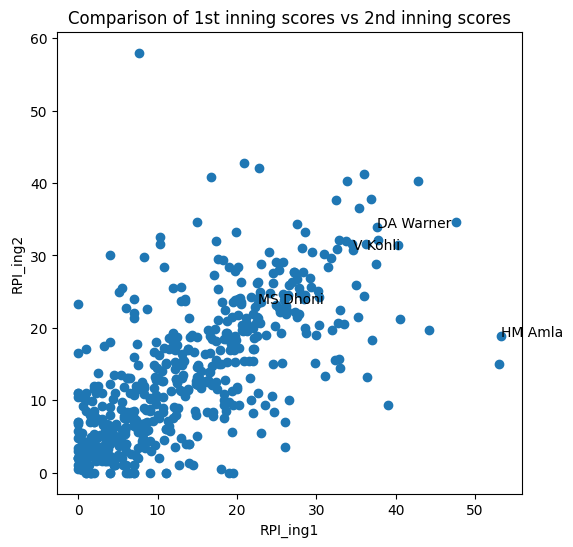

In [14]:
plt.figure(figsize=(6, 6))
selected_players=['V Kohli', 'MS Dhoni', 'HM Amla', 'DA Warner']
annotations = list(combine['batsman'])
plt.xlabel('RPI_ing1')
plt.ylabel('RPI_ing2')
plt.title('Comparison of 1st inning scores vs 2nd inning scores')

for i,j in enumerate(annotations):
    if j in selected_players:
        plt.annotate(j, (combine['RPI_ing1'][i], combine['RPI_ing2'][i]))

plt.scatter(combine['RPI_ing1'], combine['RPI_ing2'])
plt.show()

In [15]:
#by phases of play
#over 1-5: powerplay
#over 6-15: middle
#over 16-20: end

def ByPhase(df, phase_start, phase_end):

    # Filter the data for the given phase
    df = df[(df['over'] >= phase_start) & (df['over'] <= phase_end)]
    df.reset_index(inplace=True, drop=True)

    # Define binary indicators for specific events (e.g., boundaries, dot balls)
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)

    # Group data to calculate aggregated stats
    runs = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum()).reset_index().rename(columns={'batsman_runs': 'runs'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns={'matchId': 'balls'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns={'isSix': 'sixes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns={'isFour': 'fours'})
    innings=pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x))))).reset_index().rename(columns={'matchId':'innings'})
    dismissals = pd.DataFrame(df.groupby('batsman')['player_dismissed'].count()).reset_index().rename(columns={'player_dismissed': 'dismissals'})

    # Merge the aggregated stats into one DataFrame
    df = pd.merge(runs, balls, on='batsman').merge(fours, on='batsman').merge(sixes, on='batsman')

    # Calculate strike rate (runs per 100 balls)
    df['strike_rate'] = df.apply(lambda x: (x['runs'] / x['balls']) * 100 if x['balls'] > 0 else 0, axis=1)
    return df

In [16]:
powerplay_stats = ByPhase(deliveries, 1, 5)
middle_over_stats = ByPhase(deliveries, 6, 15)
death_over_stats = ByPhase(deliveries, 16, 20)

In [17]:
powerplay_stats.sort_values(by='strike_rate', ascending=False).head(10)

,batsman,runs,balls,fours,sixes,strike_rate
143,KK Cooper,7,2,0,1,350.000000
24,AD Russell,37,14,4,3,264.285714
119,J Fraser-McGurk,218,83,25,18,262.650602
306,Shahid Afridi,39,15,3,3,260.000000
65,CH Morris,17,7,2,1,242.857143
324,TM Head,348,163,43,20,213.496933
21,AD Mascarenhas,4,2,1,0,200.000000
137,K Gowtham,8,4,0,1,200.000000
314,Sunny Singh,15,8,3,0,187.500000
225,PD Salt,324,180,40,16,180.000000


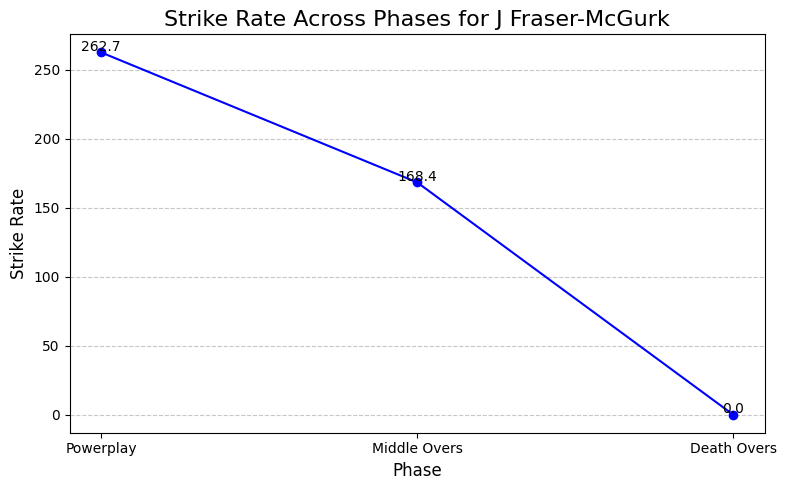

In [18]:
#strike rate by phase for a specific batsman
def plot_batsman_strike_rate(batsman_name, powerplay, middle, death):
    """
    Plot the strike rate of a batsman across different phases of play.

    Parameters:
        batsman_name (str): Name of the batsman.
        powerplay (DataFrame): DataFrame containing Powerplay stats.
        middle (DataFrame): DataFrame containing Middle Overs stats.
        death (DataFrame): DataFrame containing Death Overs stats.
    """
    # Extract strike rates for the batsman
    phases = ['Powerplay', 'Middle Overs', 'Death Overs']
    strike_rates = []

    for phase_data in [powerplay, middle, death]:
        if batsman_name in phase_data['batsman'].values:
            strike_rates.append(phase_data.loc[phase_data['batsman'] == batsman_name, 'strike_rate'].values[0])
        else:
            strike_rates.append(0)  # Assign 0 if no data for the batsman in that phase

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(phases, strike_rates, marker='o', linestyle='-', color='blue')
    plt.title(f'Strike Rate Across Phases for {batsman_name}', fontsize=16)
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Strike Rate', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Annotate data points
    for i, rate in enumerate(strike_rates):
        plt.text(i, rate + 1, f'{rate:.1f}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# Example usage
plot_batsman_strike_rate("J Fraser-McGurk", powerplay_stats, middle_over_stats, death_over_stats)

In [19]:
def strike_rate_per_over(df):
    """
    Calculate strike rates for each batsman per over.

    Parameters:
        df (DataFrame): Ball-by-ball IPL data.

    Returns:
        DataFrame: DataFrame containing batsman, over, runs, balls, and strike rate.
    """
    # Group by batsman and over to calculate runs and balls
    grouped = df.groupby(['batsman', 'over']).agg(
        runs=('batsman_runs', 'sum'),
        balls=('matchId', 'count')
    ).reset_index()

    # Calculate strike rate for each batsman per over
    grouped['strike_rate'] = (grouped['runs'] / grouped['balls']) * 100
    return grouped

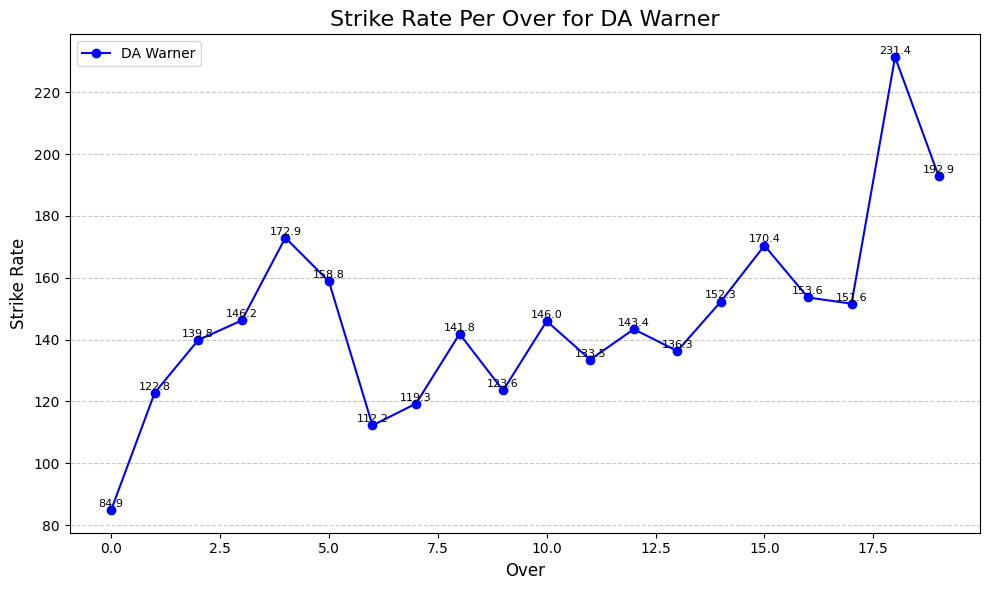

In [20]:
def plot_strike_rate_per_over(df, batsman_name):
    """
    Plot the strike rate of a batsman across overs.

    Parameters:
        df (DataFrame): DataFrame containing per-over strike rates.
        batsman_name (str): Name of the batsman to plot.
    """
    # Filter the data for the selected batsman
    batsman_data = df[df['batsman'] == batsman_name]

    if batsman_data.empty:
        print(f"No data available for batsman: {batsman_name}")
        return

    # Plot strike rate across overs
    plt.figure(figsize=(10, 6))
    plt.plot(
        batsman_data['over'],
        batsman_data['strike_rate'],
        marker='o',
        linestyle='-',
        color='blue',
        label=batsman_name
    )

    # Add labels and titles
    plt.title(f'Strike Rate Per Over for {batsman_name}', fontsize=16)
    plt.xlabel('Over', fontsize=12)
    plt.ylabel('Strike Rate', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Annotate each point with strike rate
    for _, row in batsman_data.iterrows():
        plt.text(row['over'], row['strike_rate'] + 1, f'{row["strike_rate"]:.1f}', ha='center', fontsize=8)

    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
per_over_stats = strike_rate_per_over(deliveries)
plot_strike_rate_per_over(per_over_stats, "DA Warner")

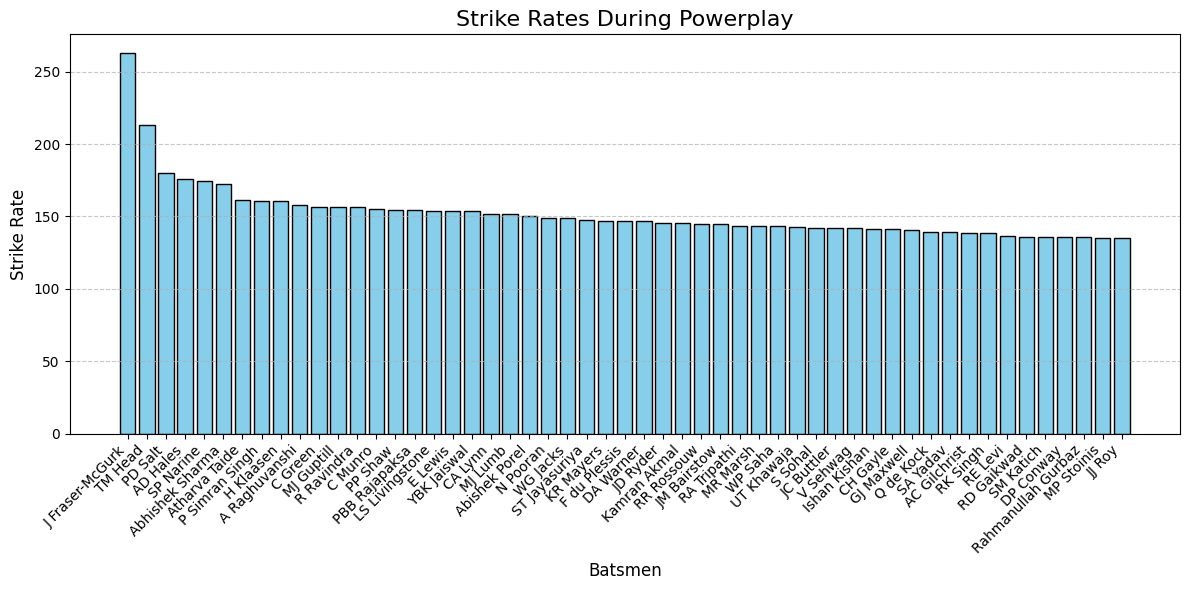

In [22]:
def plot_strike_rate(data, phase_name, min_runs=0, min_balls=0, min_strike_rate=0):
    """
    Plots a bar chart for batsmen's strike rates in a given phase, with filtering options.

    Parameters:
        data (DataFrame): The DataFrame containing batsmen and their strike rates.
        phase_name (str): Name of the phase (e.g., 'Powerplay').
        min_runs (int): Minimum runs scored by a batsman to be included in the plot (default=0).
        min_balls (int): Minimum balls faced by a batsman to be included in the plot (default=0).
        min_strike_rate (float): Minimum strike rate for batsmen to be included in the plot (default=0).
    """
    # Apply filters for minimum runs, balls faced, and strike rate
    filtered_data = data[
        (data['runs'] >= min_runs) &
        (data['balls'] >= min_balls) &
        (data['strike_rate'] >= min_strike_rate)
    ]

    if filtered_data.empty:
        print(f"No data available for players meeting the criteria in {phase_name}.")
        return

    # Sort data by strike rate for better visualization
    filtered_data = filtered_data.sort_values(by='strike_rate', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(filtered_data['batsman'], filtered_data['strike_rate'], color='skyblue', edgecolor='black')

    # Add titles and labels
    plt.title(f'Strike Rates During {phase_name}', fontsize=16)
    plt.xlabel('Batsmen', fontsize=12)
    plt.ylabel('Strike Rate', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage for powerplay phase with filters
plot_strike_rate(powerplay_stats, "Powerplay", min_runs=30, min_balls=20, min_strike_rate=135)

In [23]:
mdf= matches.copy()

In [24]:
mdf=mdf.rename(columns={'id':'matchId'})

In [25]:
comb=pd.merge(deliveries, mdf, on='matchId', how='left')
comb

,matchId,inning,over_ball,over,ball,batting_team,bowling_team,batsman,non_striker,bowler,batsman_runs,extras,isWide,isNoBall,Byes,LegByes,Penalty,dismissal_kind,player_dismissed,date_x,isDot,isOne,isTwo,isThree,isFour,isSix,eliminator,team1,neutralvenue,balls_per_over,umpire2,umpire1,outcome,venue,date1,date2,method,date_y,team2,player_of_match,winner_wickets,winner_runs,reserve_umpire,season,city,winner,match_number,event,gender,match_referee,tv_umpire,toss_winner,toss_decision
0,335982,1,0.1,0,1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,P Kumar,0,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2008-04-18,1,0,0,0,0,0,NaN,Royal Challengers Bangalore,NaN,6,RE Koertzen,Asad Rauf,NaN,M Chinnaswamy Stadium,NaN,NaN,NaN,2008-04-18,Kolkata Knight Riders,BB McCullum,NaN,140.0,VN Kulkarni,2007/08,Bangalore,Kolkata Knight Riders,1.0,Indian Premier League,male,J Srinath,AM Saheba,Royal Challengers Bangalore,field
1,335982,1,0.2,0,2,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,1,0,0,0,0,0,NaN,Royal Challengers Bangalore,NaN,6,RE Koertzen,Asad Rauf,NaN,M Chinnaswamy Stadium,NaN,NaN,NaN,2008-04-18,Kolkata Knight Riders,BB McCullum,NaN,140.0,VN Kulkarni,2007/08,Bangalore,Kolkata Knight Riders,1.0,Indian Premier League,male,J Srinath,AM Saheba,Royal Challengers Bangalore,field
2,335982,1,0.3,0,3,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,1,0,0,0,0,0,NaN,Royal Challengers Bangalore,NaN,6,RE Koertzen,Asad Rauf,NaN,M Chinnaswamy Stadium,NaN,NaN,NaN,2008-04-18,Kolkata Knight Riders,BB McCullum,NaN,140.0,VN Kulkarni,2007/08,Bangalore,Kolkata Knight Riders,1.0,Indian Premier League,male,J Srinath,AM Saheba,Royal Challengers Bangalore,field
3,335982,1,0.4,0,4,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,1,0,0,0,0,0,NaN,Royal Challengers Bangalore,NaN,6,RE Koertzen,Asad Rauf,NaN,M Chinnaswamy Stadium,NaN,NaN,NaN,2008-04-18,Kolkata Knight Riders,BB McCullum,NaN,140.0,VN Kulkarni,2007/08,Bangalore,Kolkata Knight Riders,1.0,Indian Premier League,male,J Srinath,AM Saheba,Royal Challengers Bangalore,field
4,335982,1,0.5,0,5,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,1,0,0,0,0,0,NaN,Royal Challengers Bangalore,NaN,6,RE Koertzen,Asad Rauf,NaN,M Chinnaswamy Stadium,NaN,NaN,NaN,2008-04-18,Kolkata Knight Riders,BB McCullum,NaN,140.0,VN Kulkarni,2007/08,Bangalore,Kolkata Knight Riders,1.0,Indian Premier League,male,J Srinath,AM Saheba,Royal Challengers Bangalore,field
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,2,9.5,9,5,Kolkata Knight Riders,Sunrisers Hyderabad,SS Iyer,VR Iyer,AK Markram,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-26,0,1,0,0,0,0,NaN,Sunrisers Hyderabad,NaN,6,Nitin Menon,J Madanagopal,NaN,"MA Chidambaram Stadium, Chepauk, Chennai",NaN,NaN,NaN,2024-05-26,Kolkata Knight Riders,MA Starc,8.0,NaN,VK Sharma,2024,Chennai,Kolkata Knight Riders,NaN,Indian Premier League,male,M Nayyar,MA Gough,Sunrisers Hyderabad,bat
260916,1426312,2,9.6,9,6,Kolkata Knight Riders,Sunrisers Hyderabad,VR Iyer,SS Iyer,AK Markram,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-26,0,1,0,0,0,0,NaN,Sunrisers Hyderabad,NaN,6,Nitin Menon,J Madanagopal,NaN,"MA Chidambaram Stadium, Chepauk, Chennai",NaN,NaN,NaN,2024-05-26,Kolkata Knight Riders,MA Starc,8.0,NaN,VK Sharma,2024,Chennai,Kolkata Knight Riders,NaN,Indian Premier League,male,M Nayyar,MA Gough,Sunrisers Hyderabad,bat
260917,1426312,2,10.1,10,1,Kolkata Knight Riders,Sunrisers Hyderabad,VR Iyer,SS Iyer,Shahbaz Ahmed,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-26,0,1,0,0,0,0,NaN,Sunrisers Hyderabad,NaN,6,Nitin Menon,J Madanagopal,N

In [45]:
#if the over starts from 1 the use this
#comb['over_no']= comb['over'].apply(lambda x: x-1)

In [26]:
#divide into phase this is more simpler
def get_phase(over):
    if over < 6:
        return 'Powerplay'
    elif  over < 16:
        return 'Middle'
    else:
        return 'Death'

In [27]:
def balls_per_dismissal(balls,dismissals):
  if dismissals>0:
    return balls/dismissals
  else:
    return balls/1

def balls_per_boundary(balls, boundary):
  if boundary>0:
    return balls/boundary
  else:
    return balls/1

In [28]:
comb['phase']=comb['over'].apply(get_phase)
comb

,matchId,inning,over_ball,over,ball,batting_team,bowling_team,batsman,non_striker,bowler,batsman_runs,extras,isWide,isNoBall,Byes,LegByes,Penalty,dismissal_kind,player_dismissed,date_x,isDot,isOne,isTwo,isThree,isFour,isSix,eliminator,team1,neutralvenue,balls_per_over,umpire2,umpire1,outcome,venue,date1,date2,method,date_y,team2,player_of_match,winner_wickets,winner_runs,reserve_umpire,season,city,winner,match_number,event,gender,match_referee,tv_umpire,toss_winner,toss_decision,phase
0,335982,1,0.1,0,1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,P Kumar,0,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2008-04-18,1,0,0,0,0,0,NaN,Royal Challengers Bangalore,NaN,6,RE Koertzen,Asad Rauf,NaN,M Chinnaswamy Stadium,NaN,NaN,NaN,2008-04-18,Kolkata Knight Riders,BB McCullum,NaN,140.0,VN Kulkarni,2007/08,Bangalore,Kolkata Knight Riders,1.0,Indian Premier League,male,J Srinath,AM Saheba,Royal Challengers Bangalore,field,Powerplay
1,335982,1,0.2,0,2,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,1,0,0,0,0,0,NaN,Royal Challengers Bangalore,NaN,6,RE Koertzen,Asad Rauf,NaN,M Chinnaswamy Stadium,NaN,NaN,NaN,2008-04-18,Kolkata Knight Riders,BB McCullum,NaN,140.0,VN Kulkarni,2007/08,Bangalore,Kolkata Knight Riders,1.0,Indian Premier League,male,J Srinath,AM Saheba,Royal Challengers Bangalore,field,Powerplay
2,335982,1,0.3,0,3,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,1,0,0,0,0,0,NaN,Royal Challengers Bangalore,NaN,6,RE Koertzen,Asad Rauf,NaN,M Chinnaswamy Stadium,NaN,NaN,NaN,2008-04-18,Kolkata Knight Riders,BB McCullum,NaN,140.0,VN Kulkarni,2007/08,Bangalore,Kolkata Knight Riders,1.0,Indian Premier League,male,J Srinath,AM Saheba,Royal Challengers Bangalore,field,Powerplay
3,335982,1,0.4,0,4,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,1,0,0,0,0,0,NaN,Royal Challengers Bangalore,NaN,6,RE Koertzen,Asad Rauf,NaN,M Chinnaswamy Stadium,NaN,NaN,NaN,2008-04-18,Kolkata Knight Riders,BB McCullum,NaN,140.0,VN Kulkarni,2007/08,Bangalore,Kolkata Knight Riders,1.0,Indian Premier League,male,J Srinath,AM Saheba,Royal Challengers Bangalore,field,Powerplay
4,335982,1,0.5,0,5,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,1,0,0,0,0,0,NaN,Royal Challengers Bangalore,NaN,6,RE Koertzen,Asad Rauf,NaN,M Chinnaswamy Stadium,NaN,NaN,NaN,2008-04-18,Kolkata Knight Riders,BB McCullum,NaN,140.0,VN Kulkarni,2007/08,Bangalore,Kolkata Knight Riders,1.0,Indian Premier League,male,J Srinath,AM Saheba,Royal Challengers Bangalore,field,Powerplay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,2,9.5,9,5,Kolkata Knight Riders,Sunrisers Hyderabad,SS Iyer,VR Iyer,AK Markram,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-26,0,1,0,0,0,0,NaN,Sunrisers Hyderabad,NaN,6,Nitin Menon,J Madanagopal,NaN,"MA Chidambaram Stadium, Chepauk, Chennai",NaN,NaN,NaN,2024-05-26,Kolkata Knight Riders,MA Starc,8.0,NaN,VK Sharma,2024,Chennai,Kolkata Knight Riders,NaN,Indian Premier League,male,M Nayyar,MA Gough,Sunrisers Hyderabad,bat,Middle
260916,1426312,2,9.6,9,6,Kolkata Knight Riders,Sunrisers Hyderabad,VR Iyer,SS Iyer,AK Markram,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-26,0,1,0,0,0,0,NaN,Sunrisers Hyderabad,NaN,6,Nitin Menon,J Madanagopal,NaN,"MA Chidambaram Stadium, Chepauk, Chennai",NaN,NaN,NaN,2024-05-26,Kolkata Knight Riders,MA Starc,8.0,NaN,VK Sharma,2024,Chennai,Kolkata Knight Riders,NaN,Indian Premier League,male,M Nayyar,MA Gough,Sunrisers Hyderabad,bat,Middle
260917,1426312,2,10.1,10,1,Kolkata Knight Riders,Sunrisers Hyderabad,VR Iyer,SS Iyer,Shahbaz Ahmed,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-0

In [29]:
def phasesOfplay(df, current_phase):

    df = df[df.phase == current_phase]
    df.reset_index(inplace = True, drop = True)

    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)

    runs = pd.DataFrame(df.groupby(['batsman', 'matchId'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})

    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})

    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')

    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)

    return df

In [30]:
pp_df = phasesOfplay(comb, 'Powerplay')
mid_df = phasesOfplay(comb, 'Middle')
dth_df = phasesOfplay(comb, 'Death')

In [50]:
#how good is player x against MI at wankhede with 3 spinners
#stadium = wankhede, middle phase(as there is no bowler data spin or pace), Opposition Team= MI
matches.rename(columns = {'id':'matchId'}, inplace = True)
combined_data = deliveries.merge(matches[['matchId', 'venue']], on = 'matchId', how = 'left')

In [51]:
def Bycustom(df, current_venue, current_phase, current_opposition):
    df = df[df.venue == current_venue]
    df = df[df.phase == current_phase]
    df = df[df.bowling_team == current_opposition]
    df.reset_index(inplace=True, drop=True)

    df['isDot']=df['batsman_runs'].apply(lambda x:1 if x==0 else 0)
    df['isOne']=df['batsman_runs'].apply(lambda x:1 if x==1 else 0)
    df['isTwo']=df['batsman_runs'].apply(lambda x:1 if x==2 else 0)
    df['isThree']=df['batsman_runs'].apply(lambda x:1 if x==3 else 0)
    df['isFour']=df['batsman_runs'].apply(lambda x:1 if x==4 else 0)
    df['isSix']=df['batsman_runs'].apply(lambda x:1 if x==6 else 0)

    runs=pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum()).reset_index().rename(columns={'batsman_runs':'runs'})
    balls=pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns={'matchId':'balls'})
    innings=pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x))))).reset_index().rename(columns={'matchId':'innings'})
    dismissals = pd.DataFrame(df.groupby('batsman')['player_dismissed'].count()).reset_index().rename(columns={'player_dismissed': 'dismissals'})
    sixes = pd.DataFrame(df.groupby('batsman')['isSix'].sum()).reset_index().rename(columns={'isSix': 'sixes'})
    fours = pd.DataFrame(df.groupby('batsman')['isFour'].sum()).reset_index().rename(columns={'isFour': 'fours'})
    isDot = pd.DataFrame(df.groupby('batsman')['isDot'].sum()).reset_index().rename(columns={'isDot': 'dots'})


    df=pd.merge(innings,runs, on='batsman').merge(balls, on='batsman').merge(dismissals, on='batsman').merge(fours, on='batsman').merge(sixes, on='batsman').merge(isDot, on='batsman')
    df['RPI']=df.apply(lambda x: x['runs']/x['innings'], axis=1)
    df['SR']=df.apply(lambda x: 100*(x['runs']/x['balls']), axis=1)
    df['BPD']=df.apply(lambda x: balls_per_dismissal(x['balls'],x['dismissals']), axis=1)
    df['BPB']=df.apply(lambda x: balls_per_boundary(x['balls'],(x['fours']+x['sixes'])), axis=1)
    df['dot percentage']=df.apply(lambda x: x['dots']/x['balls'], axis=1)
    return df


In [52]:

combined_data['phase']=combined_data['over'].apply(get_phase)

In [47]:
combined_data = df['dot_percentage'] = df.apply(lambda x: x['dots']/x['balls'], axis = 1)

In [53]:
combined_data = Bycustom(combined_data, 'Wankhede Stadium', 'Middle', 'Mumbai Indians')

In [54]:
combined_data

,batsman,innings,runs,balls,dismissals,fours,sixes,dots,RPI,SR,BPD,BPB,dot percentage
0,A Ashish Reddy,1,10,10,1,0,1,6,10.000000,100.000000,10.00,10.000000,0.600000
1,A Mishra,1,0,2,0,0,0,2,0.000000,0.000000,2.00,2.000000,1.000000
2,AB Agarkar,1,15,14,1,2,0,6,15.000000,107.142857,14.00,7.000000,0.428571
3,AB Dinda,1,1,1,0,0,0,0,1.000000,100.000000,1.00,1.000000,0.000000
4,AB de Villiers,6,187,113,4,22,6,28,31.166667,165.486726,28.25,4.035714,0.247788
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,WP Saha,3,79,56,1,7,4,18,26.333333,141.071429,56.00,5.090909,0.321429
152,Washington Sundar,1,7,8,1,1,0,5,7.000000,87.500000,8.00,8.000000,0.625000
153,Y Venugopal Rao,1,30,18,1,4,1,5,30.000000,166.666667,18.00,3.600000,0.277778
154,YK Pathan,6,98,94,4,9,2,36,16.333333,104.255319,23.50,8.545455,0.382979


In [ ]:
#player performance against all team

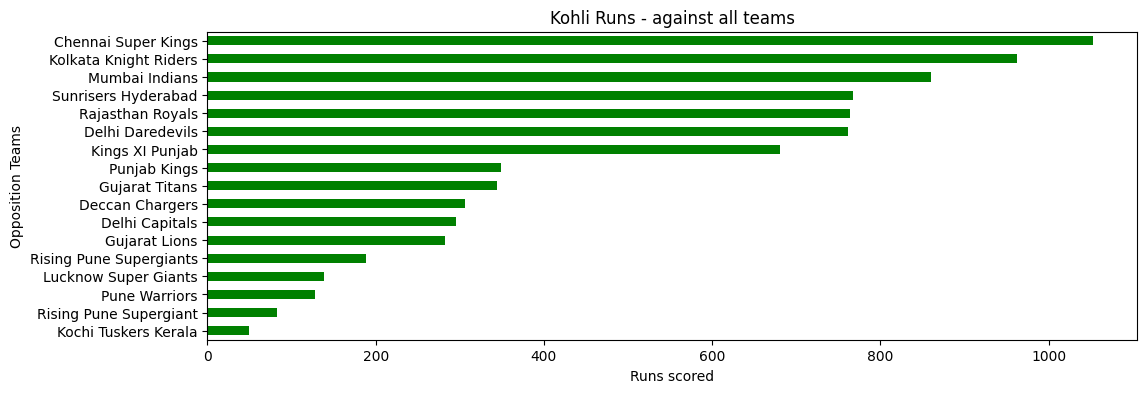

In [42]:
selected_player = 'V Kohli'
plt.figure(figsize = (12, 4))
deliveries[deliveries.batsman == selected_player].groupby(['bowling_team'])['batsman_runs'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Kohli Runs - against all teams')
plt.xlabel('Runs scored')
plt.ylabel('Opposition Teams')
plt.show()

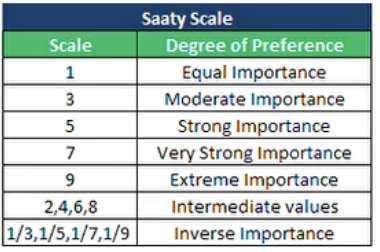

In [39]:
import numpy as np
# Pairwise comparison matrix
matrix = np.array([
    [1, 3, 5, 7],       # Strike Rate
    [1/3, 1, 3, 5],     # Runs per Innings
    [1/5, 1/3, 1, 3],   # Balls per Dismissal
    [1/7, 1/5, 1/3, 1]  # Dot Percentage
])

# Normalize the matrix
column_sum = matrix.sum(axis=0)
normalized_matrix = matrix / column_sum

# Calculate priority vector (average of rows)
priority_vector = normalized_matrix.mean(axis=1)

# Display weights
criteria = ['Strike Rate', 'Runs/Inn', 'Balls/Dismissal', 'Dot %']
weights = dict(zip(criteria, priority_vector))
print("Weights:", weights)

Weights: {'Strike Rate': 0.5578924751718869, 'Runs/Inn': 0.26334511077158135, 'Balls/Dismissal': 0.12187261268143622, 'Dot %': 0.0568898013750955}


In [40]:
wt_sr, wt_rpi, wt_bpd, wt_dot_percentage = weights.values()

In [41]:
print(df.columns)

Index(['batsman', 'innings', 'runs', 'balls', 'dismissals', 'dots', 'ones',
       'twos', 'threes', 'fours', 'sixes', 'SR', 'RPI', 'BPD', 'BPB',
       'dot_percentage'],
      dtype='object')


In [56]:
#use topsis method, minmax scaling, standardize techniques
#normalising all methods to same dimensions
#step1: square of all values
combined_data['calc_SR'] = combined_data['SR'].apply(lambda x: x*x)
combined_data['calc_RPI'] = combined_data['RPI'].apply(lambda x: x*x)
combined_data['calc_BPD'] = combined_data['BPD'].apply(lambda x: x*x)
combined_data['calc_dot_percentage'] = combined_data['dot percentage'].apply(lambda x: x*x)

sq_sr, sq_rpi, sq_bpd, sq_dot_percentage = np.sqrt(combined_data[['calc_SR', 'calc_RPI', 'calc_BPD', 'calc_dot_percentage']].sum(axis=0))

combined_data['calc_SR'] = combined_data['calc_SR'].apply(lambda x: x/sq_sr)
combined_data['calc_RPI'] = combined_data['calc_RPI'].apply(lambda x: x/sq_rpi)
combined_data['calc_BPD'] = combined_data['calc_BPD'].apply(lambda x: x/sq_bpd)
combined_data['calc_dot_percentage'] = combined_data['calc_dot_percentage'].apply(lambda x: x/sq_dot_percentage)

combined_data['calc_SR'] = combined_data['calc_SR'].apply(lambda x: x*wt_sr)
combined_data['calc_RPI'] = combined_data['calc_RPI'].apply(lambda x: x*wt_rpi)
combined_data['calc_BPD'] = combined_data['calc_BPD'].apply(lambda x: x*wt_bpd)
combined_data['calc_dot_percentage'] = combined_data['calc_dot_percentage'].apply(lambda x: x*wt_dot_percentage)

best_sr, worst_sr = max(combined_data['calc_SR']), min(combined_data['calc_SR'])
best_rpi, worst_rpi = max(combined_data['calc_RPI']), min(combined_data['calc_RPI'])
best_bpd, worst_bpd = max(combined_data['calc_BPD']), min(combined_data['calc_BPD'])
best_dot_percentage, worst_dot_percentage = min(combined_data['calc_dot_percentage']), max(combined_data['calc_dot_percentage'])


In [57]:
combined_data['dev_best_SR'] = combined_data['calc_SR'].apply(lambda x: (x-best_sr)*(x-best_sr))
combined_data['dev_best_RPI'] = combined_data['calc_RPI'].apply(lambda x: (x-best_rpi)*(x-best_rpi))
combined_data['dev_best_BPD'] = combined_data['calc_BPD'].apply(lambda x: (x-best_bpd)*(x-best_bpd))
combined_data['dev_best_dot_percentage'] = combined_data['calc_dot_percentage'].apply(lambda x: (x-best_dot_percentage)*(x-best_dot_percentage))

combined_data['dev_best_sqrt'] = combined_data.apply(lambda x: x['dev_best_SR'] + x['dev_best_RPI'] + x['dev_best_BPD'] + x['dev_best_dot_percentage'], axis=1)

combined_data['dev_worst_SR'] = combined_data['calc_SR'].apply(lambda x: (x-worst_sr)*(x-worst_sr))
combined_data['dev_worst_RPI'] = combined_data['calc_RPI'].apply(lambda x: (x-worst_rpi)*(x-worst_rpi))
combined_data['dev_worst_BPD'] = combined_data['calc_BPD'].apply(lambda x: (x-worst_bpd)*(x-worst_bpd))
combined_data['dev_worst_dot_percentage'] = combined_data['calc_dot_percentage'].apply(lambda x: (x-worst_dot_percentage)*(x-worst_dot_percentage))

combined_data['dev_worst_sqrt'] = combined_data.apply(lambda x: x['dev_worst_SR'] + x['dev_worst_RPI'] + x['dev_worst_BPD'] + x['dev_worst_dot_percentage'], axis=1)


In [58]:

combined_data = combined_data[(combined_data.innings >= 2) & (combined_data.runs > 30)]

In [59]:
#score for each player from 0-1
combined_data['score'] = combined_data.apply(lambda x: x['dev_worst_sqrt'] / (x['dev_worst_sqrt'] + x['dev_best_sqrt']), axis=1)
combined_data[['batsman', 'innings', 'runs', 'balls', 'dismissals', 'dots', 'SR', 'RPI', 'score']].sort_values(['score'], ascending=False).reset_index(drop=True).head(25)

,batsman,innings,runs,balls,dismissals,dots,SR,RPI,score
0,JC Buttler,2,132,61,1,12,216.393443,66.000000,0.987198
1,RR Pant,2,78,35,1,9,222.857143,39.000000,0.959633
2,GJ Maxwell,4,104,54,4,18,192.592593,26.000000,0.759103
3,DA Warner,2,59,32,2,11,184.375000,29.500000,0.661672
4,KK Nair,4,59,34,2,11,173.529412,14.750000,0.489822
5,AB de Villiers,6,187,113,4,28,165.486726,31.166667,0.393785
6,SV Samson,4,141,94,1,20,150.000000,35.250000,0.246329
7,SE Marsh,5,163,110,3,29,148.181818,32.600000,0.192596
8,S Dhawan,5,133,93,4,28,143.010753,26.600000,0.142794
9,WP Saha,3,79,56,1,18,141.071429,26.333333,0.133869


,batsman,innings,runs,balls,dismissals,dots,SR,RPI,score
0,JC Buttler,2,132,61,1,12,216.393443,66.000000,0.896253
1,RR Pant,2,78,35,1,9,222.857143,39.000000,0.895339
2,GJ Maxwell,4,104,54,4,18,192.592593,26.000000,0.623256
3,DA Warner,2,59,32,2,11,184.375000,29.500000,0.540338
4,KK Nair,4,59,34,2,11,173.529412,14.750000,0.417785
5,AB de Villiers,6,187,113,4,28,165.486726,31.166667,0.352373
6,SV Samson,4,141,94,1,20,150.000000,35.250000,0.263676
7,SE Marsh,5,163,110,3,29,148.181818,32.600000,0.215963
8,S Dhawan,5,133,93,4,28,143.010753,26.600000,0.178274
9,WP Saha,3,79,56,1,18,141.071429,26.333333,0.173300
